In [1]:
import sys
sys.path.append('..')
from swdf.utils import *
convert_uuids_to_indices()
import sklearn
from tsai.basics import *
my_setup(sklearn)
from swdf.plots import *

os              : Linux-6.8.0-41-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


# Predictions with FSMY 10.7 Forecast Model

This notebook compiles various plots of predictions generated by the trained model to evaluate its performance. To start, let's **load the model and the data** and make a **simple prediction for the last 6 days** (model horizon).


In [2]:
df = load_object("preprocessed_data/dataframes/solfsmy.pkl")
model_data = torch.load("models/best_model_ensemble_fsmy.pth")
data_columns = model_data['data_columns']

lookback = model_data['lookback']
horizon = model_data['horizon']
models = model_data['models']

In [3]:
lookback_data = df[data_columns].iloc[-(lookback+horizon):-horizon]

X_forecast = torch.tensor(lookback_data.values.T).float().unsqueeze(0).to(device)
X_forecast.shape

torch.Size([1, 4, 18])

In [4]:
predictions = []

with torch.no_grad():
    for model in models:
        model.eval()
        predictions.append(model(X_forecast))

predictions = torch.stack(predictions, dim=0)
predictions = predictions.mean(dim=0)

preds_df = pd.DataFrame(predictions.squeeze(0).T, columns=data_columns)

# Select the true data corresponding to the prediction period
true_df = df[df.Datetime > df.Datetime.max() - pd.DateOffset(days=6)]


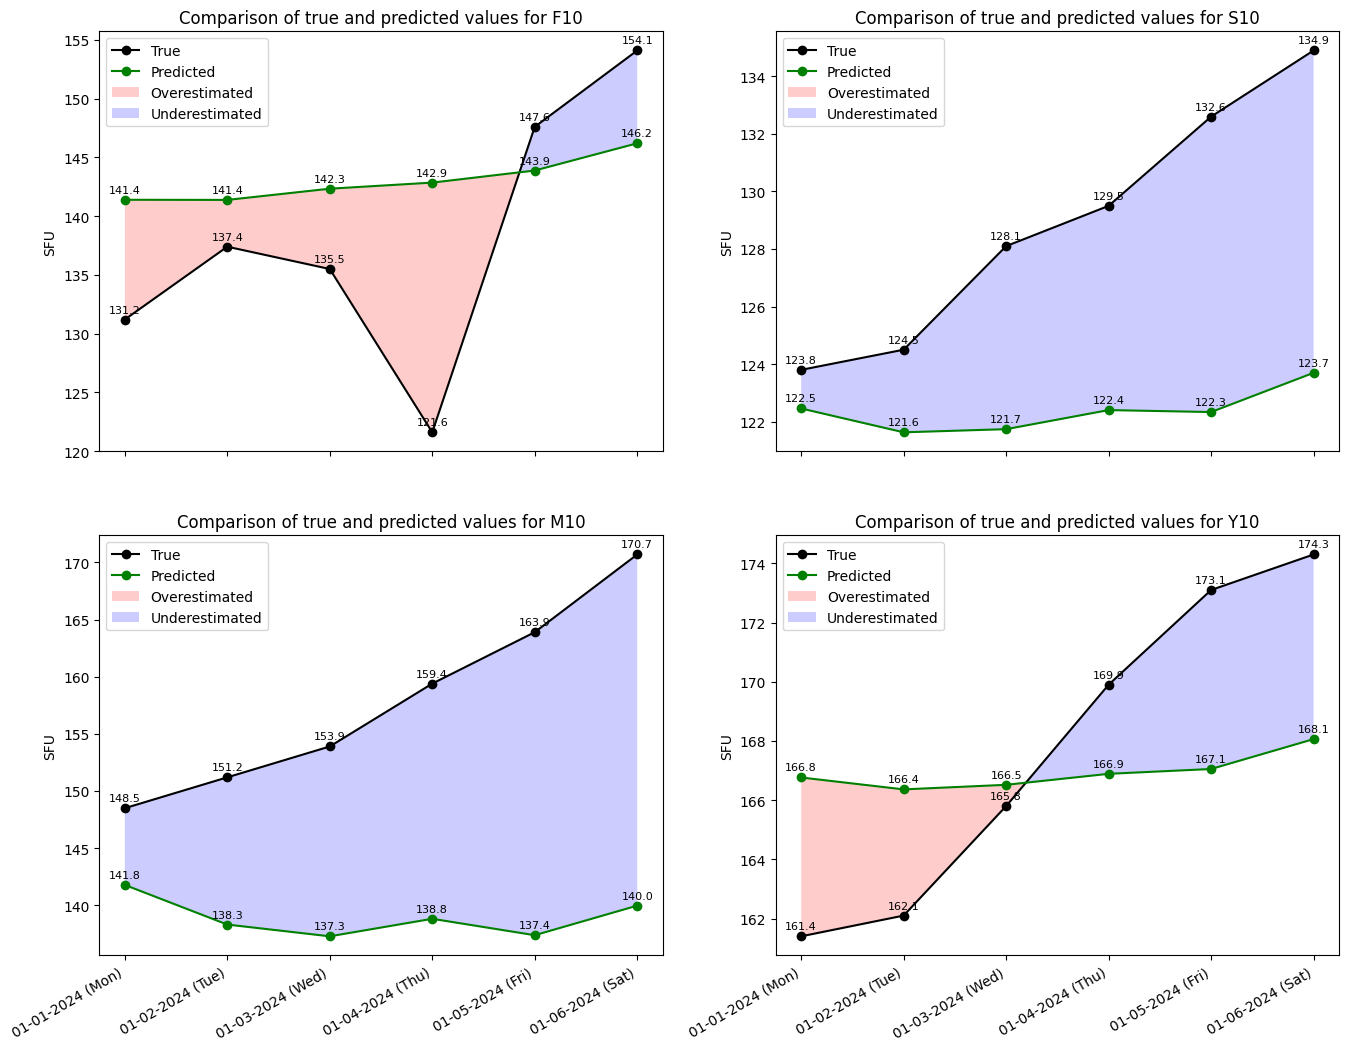

In [5]:
plot_predictions_performance(true_df, preds_df, data_columns=data_columns)

## Predictions into the Future

This model has a prediction horizon of just 6 days. For longer predictions, the simplest approach is to make them recursively by using the output values from the last 6 predictions as inputs for the next ones. However, since we are predicting into the future, we cannot evaluate the performance—only observe the results produced by the model.

> **Important:** Recursive predictions tend to stabilize towards a mean value quickly, so they are not suitable for predicting over long periods.


Timestamp('2024-01-06 12:00:00')

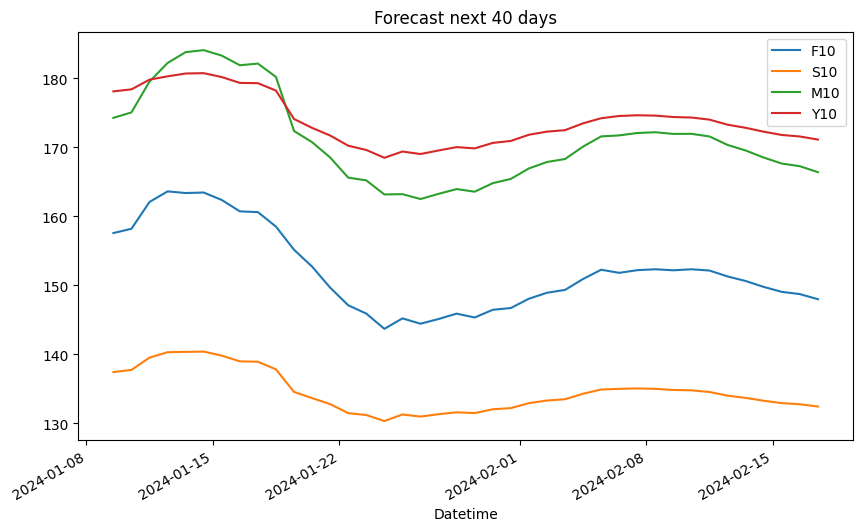

In [6]:
days_to_forecast = 40
to_forecast_df = df.iloc[-lookback:]

def recurent_forecasting(df, days_to_forecast=12):
    to_forecast_df = df.copy()
    forecasted_days = 0

    while forecasted_days < days_to_forecast:
        lookback_data = to_forecast_df[data_columns].iloc[-lookback:]

        X_forecast = torch.tensor(lookback_data.values.T).float().unsqueeze(0).to(device)

        with torch.no_grad():
            predictions = model(X_forecast)

        dates = [to_forecast_df.Datetime.max() + dt.timedelta(days=j) for j in range(1, 7)]
        pred_df = pd.DataFrame(predictions.squeeze(0).T, columns=data_columns)
        pred_df['Datetime'] = dates
        to_forecast_df = pd.concat([to_forecast_df, pred_df], axis=0, ignore_index=True).reset_index(drop=True)
        
        forecasted_days += len(dates)
    
    return to_forecast_df

forecasts = recurent_forecasting(to_forecast_df, days_to_forecast)
forecasts.iloc[-days_to_forecast:].plot(x='Datetime', y=['F10', 'S10', 'M10', 'Y10'], figsize=(10, 6), title=f'Forecast next {days_to_forecast} days')
    


df.Datetime.max()

However, the performance for short periods is quite reasonable, as demonstrated here using the recurrent forecasting method to predict values 12 time steps into the future.


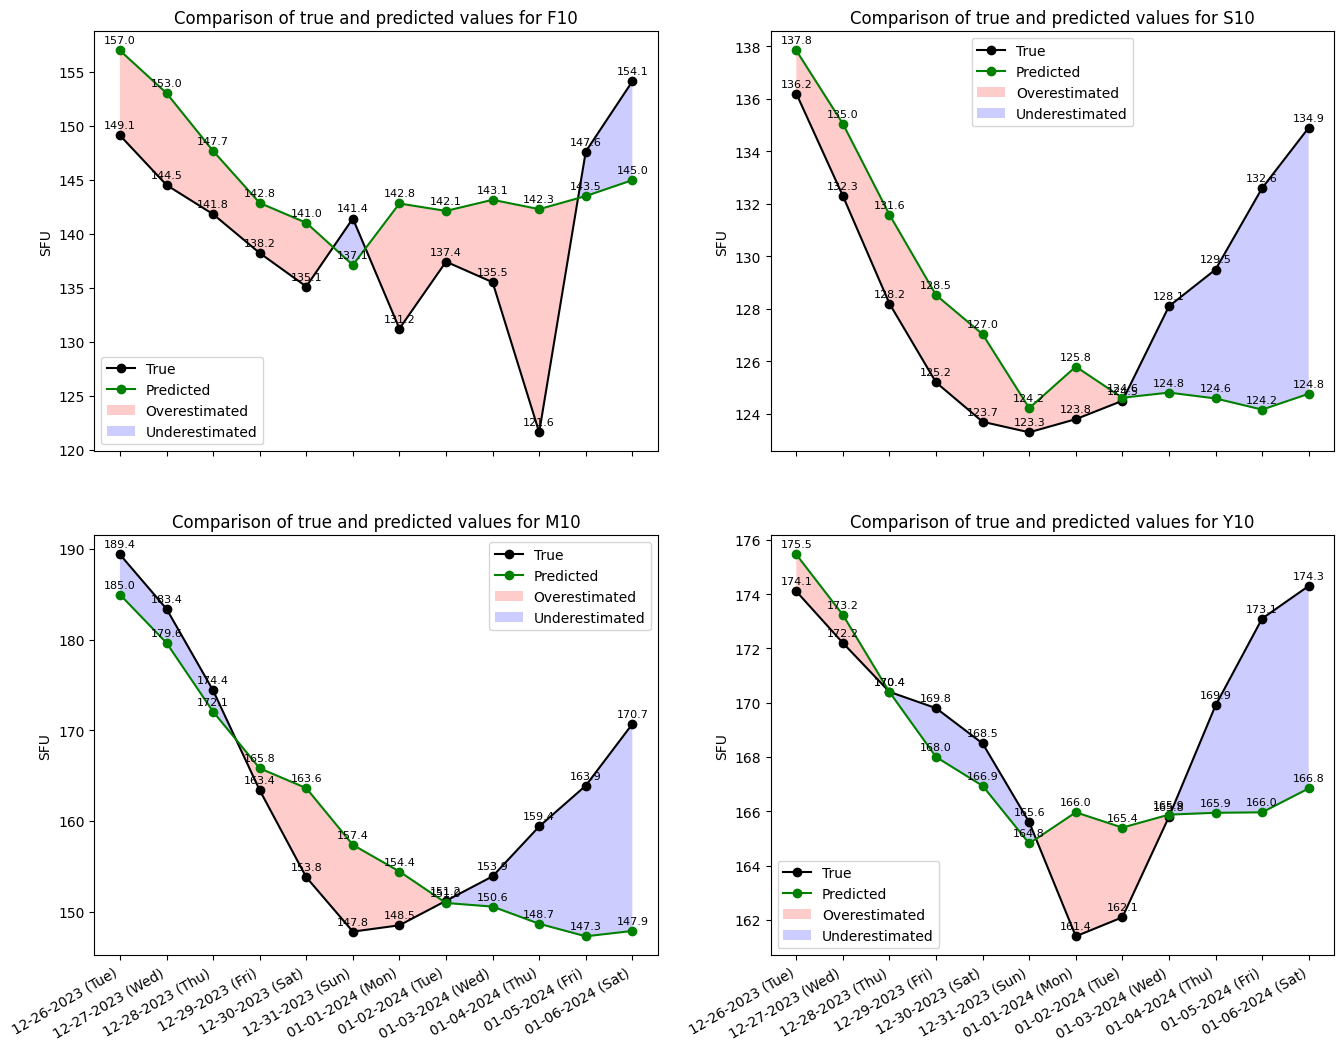

In [7]:
days_to_forecast = 12

to_forecast_df = df.iloc[-(lookback+days_to_forecast):-days_to_forecast]

preds_df = recurent_forecasting(to_forecast_df, days_to_forecast)[data_columns].iloc[-(days_to_forecast):]
true_df = df[data_columns + ['Datetime']].iloc[-(days_to_forecast):]
plot_predictions_performance(true_df, preds_df, data_columns=data_columns)

## Deeper Prediction Analysis 

For a deeper analysis of our prediction, we have replicated some of the National Oceanic and Atmospheric Administration (NOAA) plots to show how well the performance for each time step is being.

In [8]:
start_date = pd.Timestamp('2023-03-10')
end_date = pd.Timestamp('2023-05-17')

X_tensor = prepare_tensor_to_forecast_histogram(
    df, 
    AttrDict(model_data), 
    start_date=start_date,
    end_date=end_date
)
model.eval()

with torch.no_grad():
    preds = model(X_tensor)

true_df = df[(df.Datetime >= start_date) & (df.Datetime <= end_date)] 
 
preds.shape

torch.Size([75, 4, 6])

This plot may be a bit difficult to read, so let's break it down into easier parts to understand it better:

- The **black line** represents the true values of the index.
- The **heatmap** in the background shows how the model has performed for each time step. 

To interpret the heatmap:
- Each box indicates how much the model has **overestimated** (red) or **underestimated** (blue) the real predictions.
- Each column of heatmap squares represents the model's predictions over the horizon. Specifically, the model makes a prediction starting from the date shown on the x-axis and forecasts 6 days into the future.
- The top square in each column represents the prediction for day $t_{n+1}$, followed by $t_{n+2}$, and so on, down to $t_{n+6}$ at the bottom.

For example, if you look at the first column of squares, you are observing the model's performance in forecasting the values from **2024-03-12** (top rectangle) to **2024-03-18** (bottom rectangle).


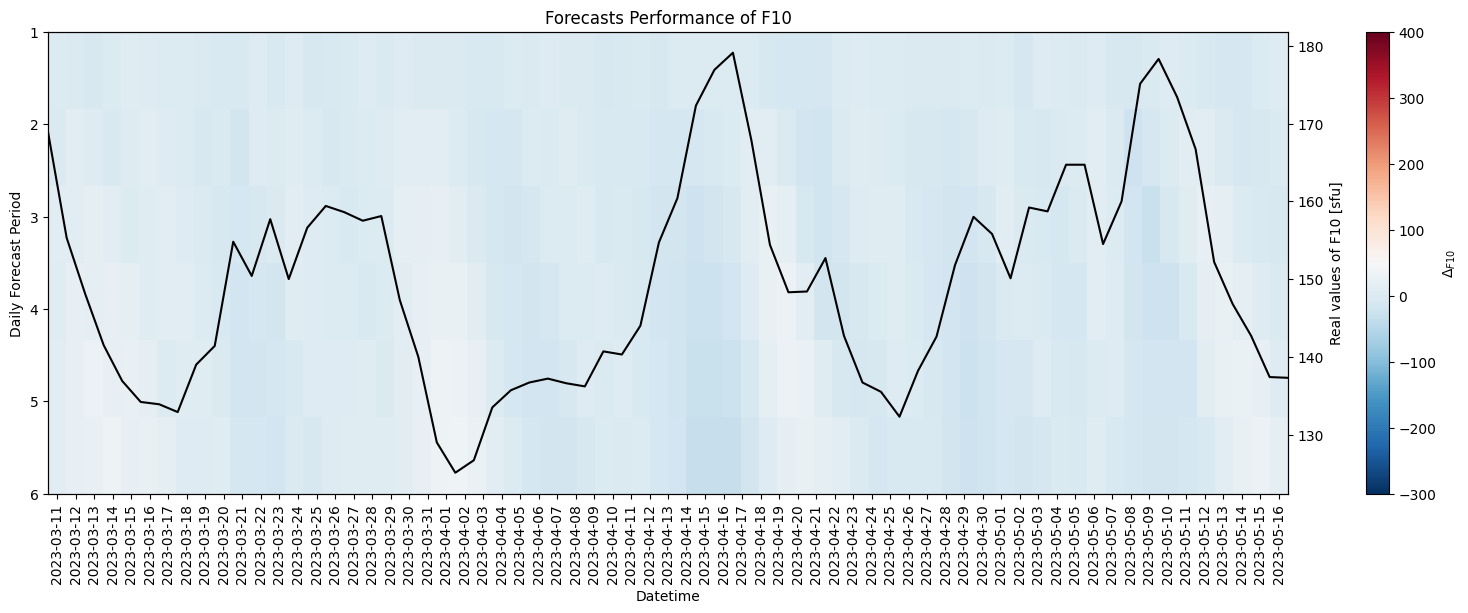

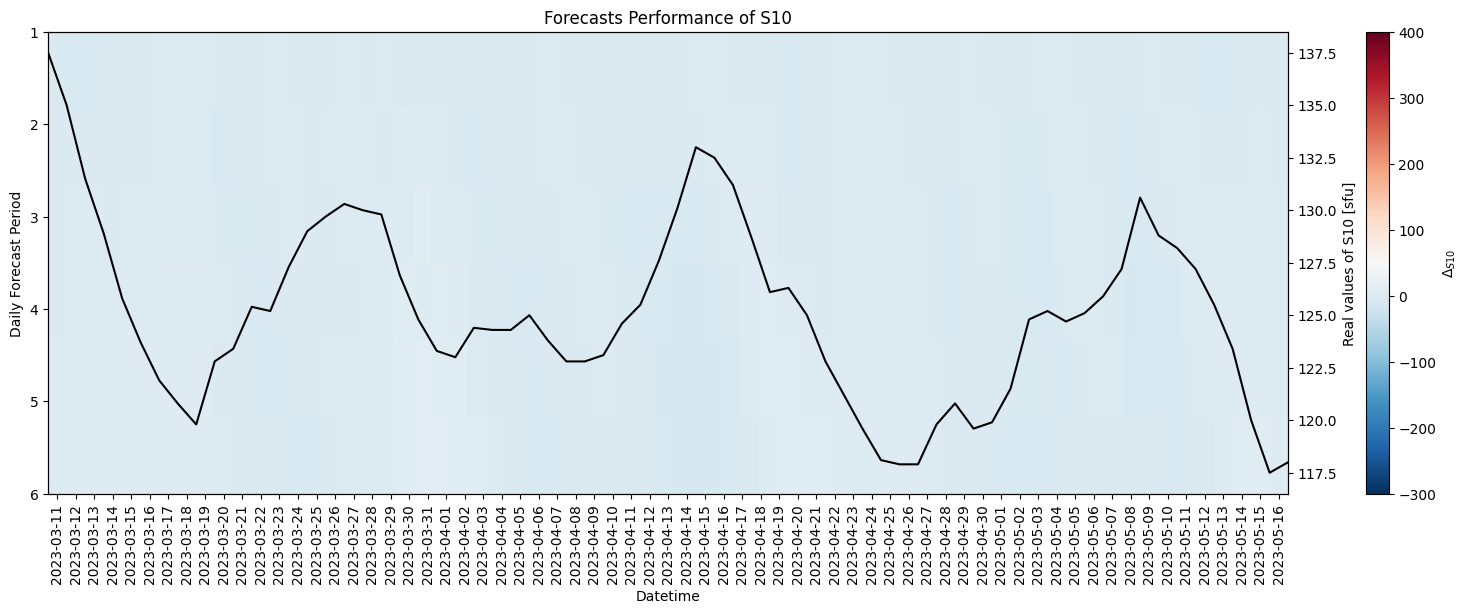

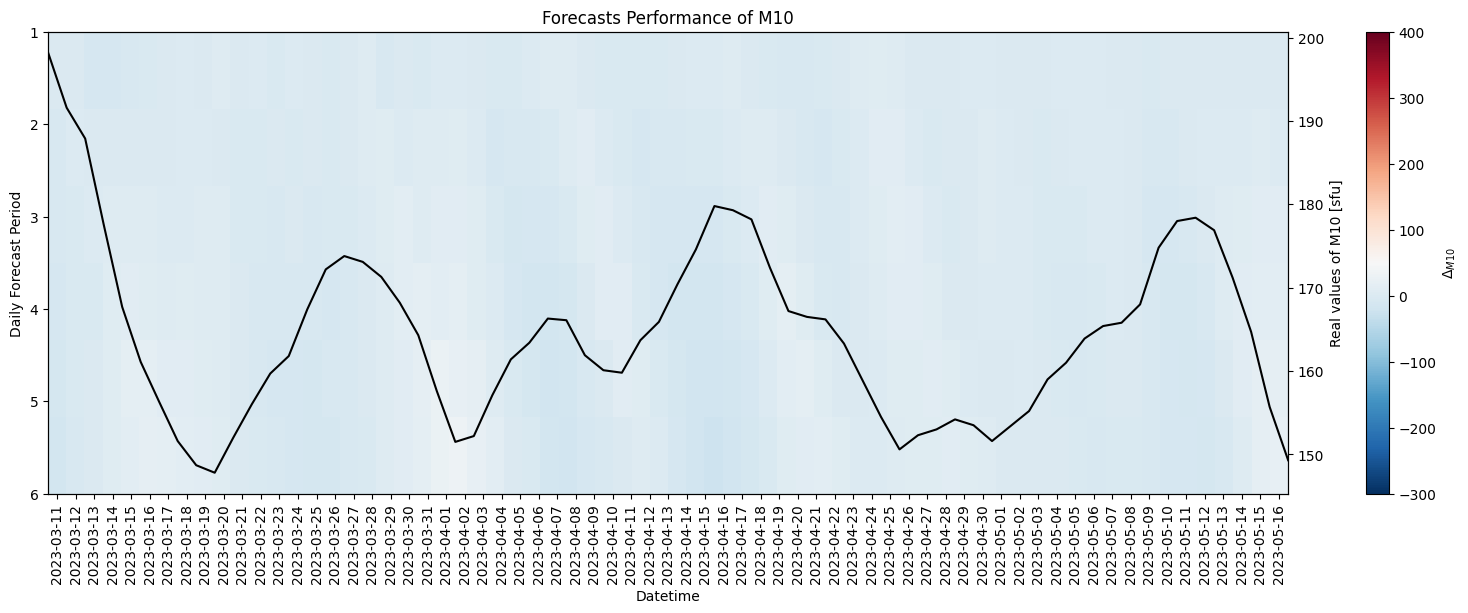

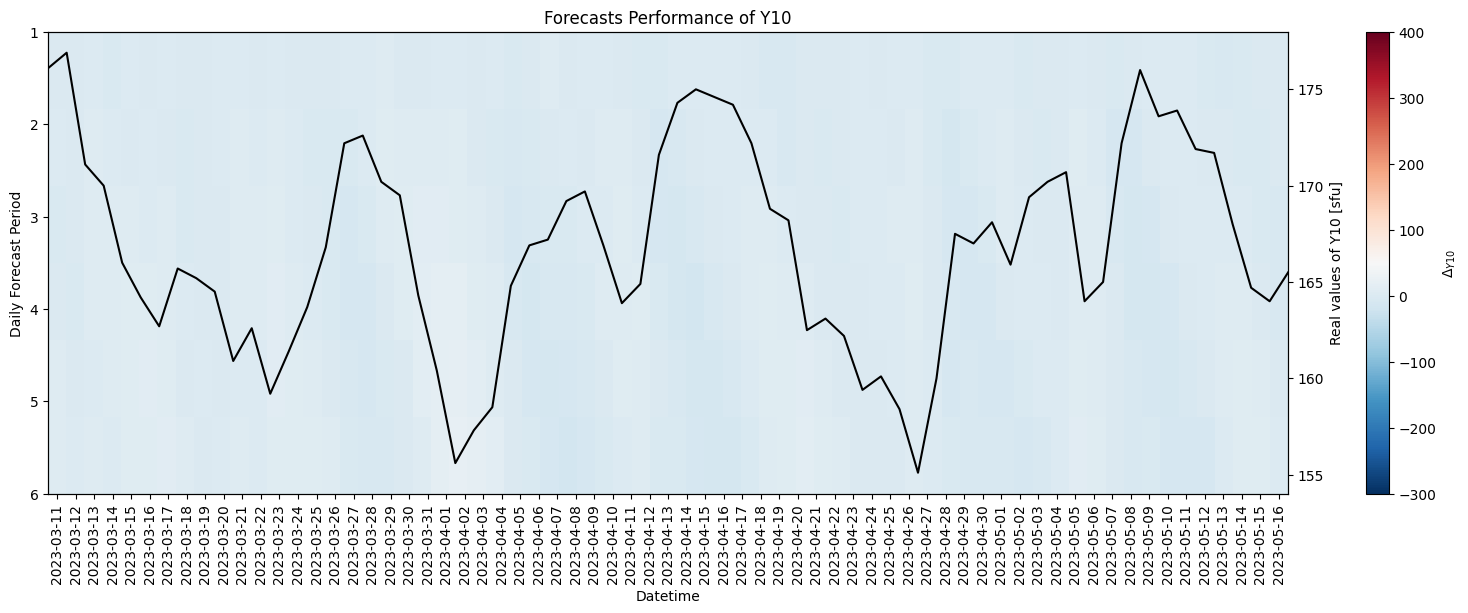

In [9]:

plot_histogram_with_accuracy_preds(
    true_df, 
    preds,
    data_columns=data_columns
)